In [64]:
%reset -f

In [75]:
from IPython.display import display, HTML
from sklearn import metrics
from sklearn import cross_validation
from scipy import interp
import pandas as pd
import numpy as np
import os

from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import cross_validate

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.4f}'.format
plt.style.use('classic')

%matplotlib inline

#### Load domain data & methods

In [66]:
import sys
sys.path.insert(1, "../src/")
from TypeFeatImputer import TypeFeatImputer
from UnivCombineFilter import UnivCombineFilter
import MLpipeline as MLpipeline
import readmision_methods as rm

In [77]:
verbose = True
cv_thr = 0.3
cv_folds = 5

tr_thrs = [1.0] # [0.1,0.2,0.4,0.6,1.0]
ts_thr = 0.30

typeEncounter = "last" # ['first','last']
typeHypothesis = "all_readmisssion_vs_none" # ['all_readmisssion_vs_none','early_readmission_vs_none']
typeDataFeatures = "reduced" # ["reduced","extended','extended_extra','extended_extra_diag_1','extended_extra_diag_3']
    #Extended_Extra_diag_1 -> Extended extra columns with disease in diag_3
    #Extended_Extra_diag_1 -> Extended extra columns with disease in diag_1
    #Extended_Extra -> Extended extra of columns
    #Extended -> Extended columns
    #Reduced -> minimum set of columns 
typeDataExperiment = "disease" #["all", "disease"] 
    #all -> No filter disease column
    #disease -> Filter/Remove disease column and keep only rows with diagnosis column == 1  

#name = typeDataExperiment + "_" + typeDataFeatures + "_" +  typeEncounter + "_" + typeHypothesis
name = typeDataFeatures + "_" +  typeEncounter + "_" + typeHypothesis

print name

reduced_last_all_readmisssion_vs_none


In [81]:
#Load data
df_all = rm.load_data(typeEncounter, typeDataFeatures)
print "\nSHAPE:"
print df_all.shape

#Filter data by class
df_all = rm.filter_data_by_class(df_all, typeHypothesis)
print "\nSHAPE AFTER FILTERING:"
print df_all.shape

print "\nRows by class type:"
print df_all.iloc[:,-1].sort_values().unique(), np.sum(df_all["readmitted"] == 0), np.sum(df_all["readmitted"] == 1)

#Train & Test
X_train, X_test, y_train, y_test = MLpipeline.train_test_partition(df_all)
print "\nTrain:", X_train.shape, "Test:",  X_test.shape

#CV data
cv_outer = StratifiedShuffleSplit(y_train, n_iter=cv_folds, test_size=cv_thr, random_state=42)
print "\n CV:", "Train", cv_outer.n_train, "test:", cv_outer.n_test


SHAPE:
(67182, 42)

SHAPE AFTER FILTERING:
(67182, 42)

Rows by class type:
[0 1] 39785 27397

Train: (47027, 41) Test: (20155, 41)

 CV: 32918 14109


#### Load pipeline results

In [93]:
fname = "summary_reduced_last_all_readmisssion_vs_none_20171025-115456.pkl"
class_names = ["Non-readmission","Readmission"]


pathDir = os.path.join('resources','results') 


dd = pd.read_pickle(os.path.join(pathDir,fname))
dd.index = range(0,dd.shape[0])
print dd.columns
print dd.shape
dd[["sm","fs","metric","cls","params",
    "tr_auc","tr_sens","tr_spec",
    "cv_auc_mean","cv_f1_mean","cv_sens_mean","cv_spec_mean",
    "test_auc","test_f1","test_sens","test_spec"]]

Index([u'exp', u'name', u'size_tr', u'fs', u'sm', u'cls', u'metric', u'params',
       u'tr_sens', u'tr_spec', u'tr_auc', u'tr_prec', u'tr_rec', u'tr_f1',
       u'cv_sens_mean', u'cv_sens_std', u'cv_spec_mean', u'cv_spec_std',
       u'cv_auc_mean', u'cv_auc_std', u'cv_prec_mean', u'cv_prec_std',
       u'cv_rec_mean', u'cv_rec_std', u'cv_f1_mean', u'cv_f1_std',
       u'test_sens', u'test_spec', u'test_auc', u'test_rec', u'test_prec',
       u'test_f1', u'cm_test', u'time', u'pipeline', u'cv_auc', u'cv_f1',
       u'cv_sens', u'cv_spec', u'disease'],
      dtype='object')
(6, 40)


,sm,fs,metric,cls,params,tr_auc,tr_sens,tr_spec,cv_auc_mean,cv_f1_mean,cv_sens_mean,cv_spec_mean,test_auc,test_f1,test_sens,test_spec
0,none,none,f1_weighted,rf,"[gini, 12, 400]",0.6936,0.6732,0.7140,0.6536,0.6153,0.5659,0.6462,0.6101,0.6175,0.5833,0.6369
1,none,none,f1,rf,"[gini, 8, 350]",0.6234,0.6062,0.6407,0.6493,0.6121,0.5836,0.6271,0.6077,0.6131,0.5947,0.6207
2,none,none,recall,rf,"[gini, 8, 350]",0.6236,0.6064,0.6409,0.6493,0.6121,0.5836,0.6271,0.6078,0.6131,0.5947,0.6208
3,none,none,f1_weighted,logReg,"[balanced, 0.005, l2]",0.5978,0.5673,0.6282,0.6382,0.6027,0.5607,0.6276,0.5971,0.6050,0.5678,0.6263
4,none,none,f1,logReg,"[balanced, 0.0001, l2]",0.5940,0.5807,0.6073,0.6307,0.5941,0.5772,0.6003,0.5930,0.5984,0.5806,0.6053
5,none,none,recall,logReg,"[balanced, 1e-05, l2]",0.5858,0.5911,0.5805,0.6207,0.5854,0.5881,0.5776,0.5884,0.5906,0.5957,0.5811


#### Plot SELECTED pipelines

(-0.05, 5.05)

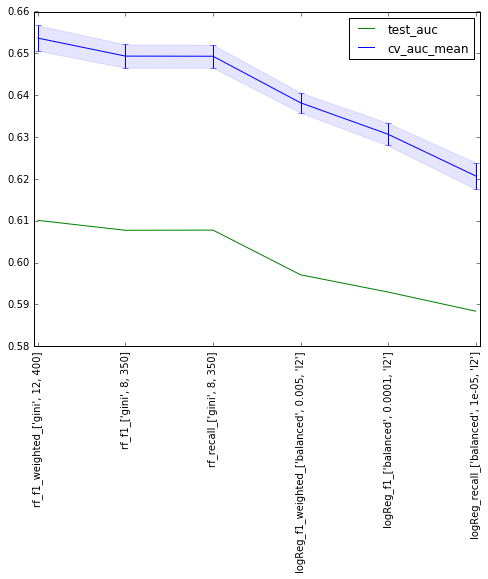

In [73]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
dd[["test_auc"]].plot(ax=ax,y="test_auc", color="g")
dd[["cv_auc_mean", "cv_auc_std"]].plot(ax=ax, y="cv_auc_mean", yerr="cv_auc_std",color="b")
ax.fill_between(dd.index,dd.cv_auc_mean - dd.cv_auc_std, dd.cv_auc_mean + dd.cv_auc_std, alpha=0.1,color="b")


txt = [dd["cls"].iloc[i] + "_" + str(dd.iloc[i].metric) + "_"+ str(dd.iloc[i].params) for i in range(dd.shape[0])]
plt.xticks(dd.index,txt,rotation=90)
plt.xlim(-0.05,5.05)

#### Plot best pipeline

In [84]:
cls_name = dd["cls"].iloc[0] + "_" + str(dd.iloc[0].metric) + "_"+ str(dd.iloc[0].params)
cls = dd.iloc[0].pipeline

Pipeline(memory=None,
     steps=[('Imputer', TypeFeatImputer(allNameCols=Index([u'gender', u'age', u'race_AfricanAmerican', u'race_Caucasian',
       u'race_Other', u'HbA1c', u'Change', u'time_in_hospital', u'diabetesMed',
       u'diss_home', u'medSpec_cardio', u'medSpec_Family/GeneralPractice',
       u'medSpec_InternalMed...imators=400, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])


#### ROC curve

[0 0 1 ..., 1 0 0]
[1 0 0 ..., 0 1 0]

0.610009931094
[ 0.         0.5830393  1.       ]
[ 0.          0.36301944  1.        ]


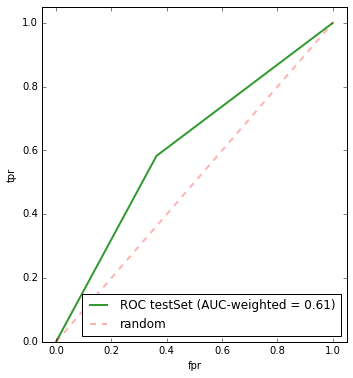

In [88]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

#y_score = cls.decision_function(X_test) #For D0 & D1
y_pred = cls.predict(X_test)
y_prob = cls.predict_proba(X_test)
    
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred)
#fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_score, pos_label=1)

test_auc_w = metrics.auc(fpr_test, tpr_test) 
#test_auc_w = metrics.roc_auc_score(y_test, y_score, average='weighted')

print y_test
print y_pred
print
print test_auc_w
print tpr_test
print fpr_test

plt.figure(figsize=(12,6))

ax = plt.subplot(1,2,1)
ax.plot(fpr_test, tpr_test, color="g",
         label='ROC test (AUC = %0.2f)' % (test_auc_w),lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.3)
ax.legend(loc='lower right')
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_xlim(-0.05,1.05)
ax.set_ylim(0,1.05)
plt.show()

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([ 0.        ,  0.19993264,  0.39986528,  0.58000838,  0.66400671,
        0.74800503,  0.83200335,  0.91600168,  1.        ])

array([ 0.        ,  0.19779388,  0.39558775,  0.58176802,  0.66598912,
        0.74949184,  0.83299456,  0.91649728,  1.        ])

array([ 0.        ,  0.19707312,  0.39414624,  0.58233158,  0.66663154,
        0.74997366,  0.83331577,  0.91665789,  1.        ])

array([ 0.        ,  0.19486268,  0.38972536,  0.57730406,  0.66248184,
        0.74686138,  0.83124092,  0.91562046,  1.        ])

array([ 0.        ,  0.19199937,  0.38399873,  0.57017091,  0.65955426,
        0.74466569,  0.82977713,  0.91488856,  1.        ])

array([ 0.        ,  0.18900741,  0.37801482,  0.56216624,  0.65686229,
        0.74264672,  0.82843115,  0.91421557,  1.        ])

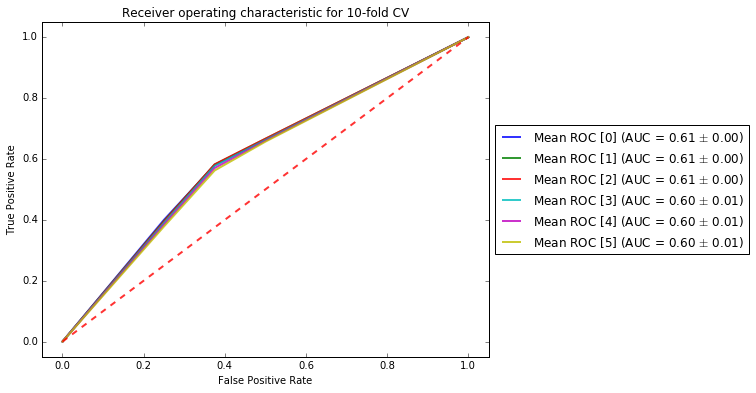

In [82]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 9)

i = 0

plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
for exp in dd.exp.values:
    
    cls_name = dd[dd.exp == exp].index.values
    cls = dd[dd.exp == exp].pipeline.iloc[0]

    for train, test in cv_outer:

        y_pred = cls.fit(X_train[train],y_train[train]).predict(X_train[test])

        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_train[test], y_pred)

        tprs.append(interp(mean_fpr, fpr, tpr))  
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)    

        aucs.append(roc_auc)
        i += 1

    #Plot auc mean line and shadow mean area
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    display(mean_tpr)

    ax.plot(mean_fpr, mean_tpr,
             label=r'Mean ROC %s (AUC = %0.2f $\pm$ %0.2f)' % (cls_name,mean_auc, std_auc),
             lw=2, alpha=.8)
    
#Plot guess line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 10-fold CV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()  

#### Classification probabilities

Pipeline(memory=None,
     steps=[('Imputer', TypeFeatImputer(allNameCols=Index([u'gender', u'age', u'race_AfricanAmerican', u'race_Caucasian',
       u'race_Other', u'HbA1c', u'Change', u'time_in_hospital', u'diabetesMed',
       u'diss_home', u'medSpec_cardio', u'medSpec_Family/GeneralPractice',
       u'medSpec_InternalMed...imators=400, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])
[ 0.52728229  0.45320818  0.37108323 ...,  0.44520537  0.53490864
  0.45934331]


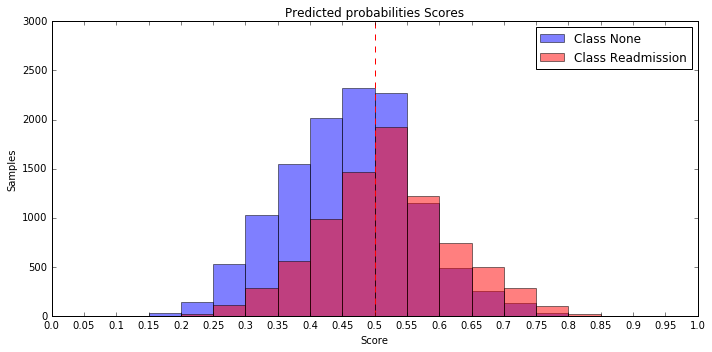

In [92]:
# Plot the two-class decision scores
plot_colors = "br"
plot_step = 0.02

twoclass_output = cls.predict_proba(X_test)[:,1]
plot_range = (twoclass_output.min(), twoclass_output.max())
print cls
print twoclass_output


plt.figure(figsize=(10, 5))
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y_test == i],
             bins=20,
             range=(0,1.0),
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Predicted probabilities Scores')
plt.axvline(0.5,label="Default threshold",c="r",ls="--")
plt.xticks(np.arange(0,1.05,0.05), np.arange(0,1.05,0.05))
plt.xlim(0,1)
plt.tight_layout()

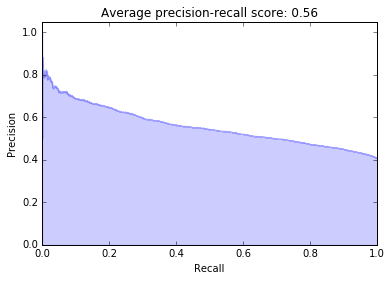

In [96]:
if "rf" in cls_name:    
    y_prob = cls.predict_proba(X_test)
    average_precision = metrics.average_precision_score(y_test, y_prob[:,1], average="macro")
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob[:,1])
else: 
    y_score = cls.decision_function(X_test)
    average_precision = metrics.average_precision_score(y_test, y_score, average="macro")
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision-recall score: {0:0.2f}'.format(average_precision))
plt.show()

In [97]:
### Classification boundaries

In [101]:
#pca
from sklearn.decomposition import PCA

print X_test.shape

X_test_trans = X_test.copy()
for s in range(len(cls.steps) - 1):
    if cls.steps[s][0] != "sm_smote":
        X_test_trans = cls.steps[s][1].transform(X_test_trans)  

X_train_trans = X_train.copy()
for s in range(len(cls.steps) - 1):
    if cls.steps[s][0] != "sm_smote":
        X_train_trans = cls.steps[s][1].transform(X_train_trans)  

pca = PCA(n_components=2)
X_r = pca.fit(X_train_trans).transform(X_test_trans)


print('explained variance ratio (first components): %s'
      % str(pca.explained_variance_ratio_))
print "explained variance ratio of 2 pcas:", np.sum(pca.explained_variance_ratio_[:2])

(20155, 41)
explained variance ratio (first components): [ 0.08093311  0.06435579]
explained variance ratio of 2 pcas: 0.145288900178


In [102]:
#Make meshgrid

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .1     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_r[:, 0].min() - 2, X_r[:, 0].max() + 2
y_min, y_max = X_r[:, 1].min() - 2, X_r[:, 1].max() + 2
print x_min, x_max
print y_min, y_max

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
print xx.shape, np.min(xx), np.max(xx)
print yy.shape, np.min(yy), np.max(yy)

X_extra = np.c_[xx.ravel(), yy.ravel()]
x_min_extra, x_max_extra = X_extra[:, 0].min(), X_extra[:, 0].max()
y_min_extra, y_max_extra = X_extra[:, 1].min(), X_extra[:, 1].max()
print x_min_extra, x_max_extra
print y_min_extra, y_max_extra
print X_extra.shape

X_extra_trans = pca.inverse_transform(X_extra)
print X_extra_trans.shape

-6.2695459338 5.34219449514
-6.54248087982 8.23930802014
(148, 117) -6.2695459338 5.3304540662
(148, 117) -6.54248087982 8.15751912018
-6.2695459338 5.3304540662
-6.54248087982 8.15751912018
(17316, 2)
(17316, 41)


In [103]:
# Obtain labels for each point in mesh. Use last trained model
Z = cls.steps[-1][1].predict(X_extra_trans)
print Z.shape
print np.sum(Z==0), np.sum(Z==1)

y_pred_ts = cls.predict(X_test)
print np.sum(y_pred_ts==0), np.sum(y_pred_ts==1)


y_pred_cs = []
for d in range(len(y_pred_ts)):
    if y_pred_ts[d] == y_test[d]:
        if y_pred_ts[d] == 0:
            y_pred_cs.append("blue")
        else:
            y_pred_cs.append("g")
    else:
        y_pred_cs.append("r")

y_pred_cs = np.array(y_pred_cs)
print y_pred_cs
print "Pred errors:", np.sum(y_pred_cs=="r")

(17316,)
9191 8125
11028 9127
['r' 'blue' 'r' ..., 'r' 'r' 'blue']
Pred errors: 7758


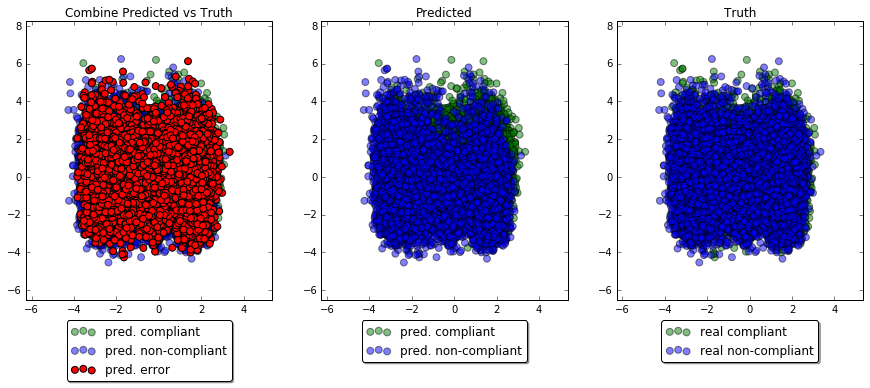

In [104]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)

#Predicted
#ax.scatter(X_r[:, 0], X_r[:, 1], c=y_pred_cs)
ax.scatter(X_r[y_pred_cs=="g", 0], X_r[y_pred_cs=="g", 1], c=["g" for y in y_pred_ts[y_pred_cs=="g"]],label="pred. compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_pred_cs=="blue", 0], X_r[y_pred_cs=="blue", 1], c=["blue" for y in y_pred_ts[y_pred_cs=="blue"]],label="pred. non-compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_pred_cs=="r", 0], X_r[y_pred_cs=="r", 1], c=["r" for y in y_pred_ts[y_pred_cs=="r"]],label="pred. error", s=48)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Combine Predicted vs Truth")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=1)

ax = plt.subplot(1,3,2)
ax.scatter(X_r[y_pred_ts==1, 0], X_r[y_pred_ts==1, 1], c=["g" for y in y_pred_ts[y_pred_ts==1]],label="pred. compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_pred_ts==0, 0], X_r[y_pred_ts==0, 1], c=["blue" for y in y_pred_ts[y_pred_ts==0]],label="pred. non-compliant", alpha=0.5, s=48)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Predicted")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=1)

ax = plt.subplot(1,3,3)
#ax.scatter(X_r[:, 0], X_r[:, 1], c=["g" if y else "blue" for y in y_test], alpha=0.3)
ax.scatter(X_r[y_test==1, 0], X_r[y_test==1, 1], c=["g" for y in y_pred_ts[y_test==1]],label="real compliant", alpha=0.5, s=48)
ax.scatter(X_r[y_test==0, 0], X_r[y_test==0, 1], c=["blue" for y in y_pred_ts[y_test==0]],label="real non-compliant", alpha=0.5, s=48)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Truth")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=1)

plt.show()

In [105]:
#### Interpretability

In [126]:
display(dd[["tr_auc","tr_sens","tr_spec",
    "cv_auc_mean","cv_f1_mean","cv_sens_mean","cv_spec_mean",
    "test_auc","test_f1","test_sens","test_spec"]].iloc[0,:])



tr_auc         0.6936
tr_sens        0.6732
tr_spec        0.7140
cv_auc_mean    0.6536
cv_f1_mean     0.6153
cv_sens_mean   0.5659
cv_spec_mean   0.6462
test_auc       0.6101
test_f1        0.6175
test_sens      0.5833
test_spec      0.6369
Name: 0, dtype: object

Index([u'gender', u'age', u'race_AfricanAmerican', u'race_Caucasian',
       u'race_Other', u'HbA1c', u'Change', u'time_in_hospital', u'diabetesMed',
       u'diss_home', u'medSpec_cardio', u'medSpec_Family/GeneralPractice',
       u'medSpec_InternalMedicine', u'medSpec_surgery', u'adm_src_1',
       u'adm_src_2', u'adm_src_3', u'adm_src_4', u'adm_src_5', u'adm_src_6',
       u'adm_src_7', u'adm_src_8', u'adm_src_10', u'adm_src_11', u'adm_src_13',
       u'adm_src_14', u'adm_src_22', u'adm_src_25', u'adm_1', u'adm_2',
       u'adm_3', u'adm_4', u'adm_7', u'number_treatment',
       u'num_lab_procedures', u'num_procedures', u'num_medications',
       u'number_outpatient', u'number_emergency', u'number_inpatient',
       u'number_diagnoses'],
      dtype='object')
41
41


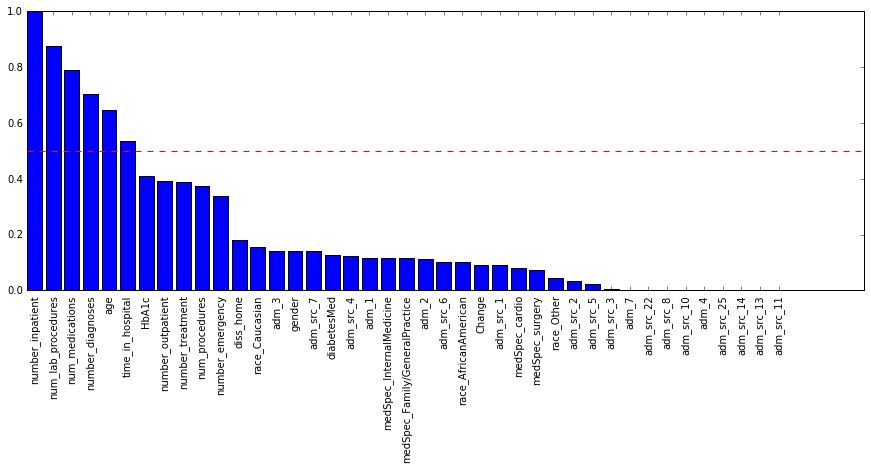

In [117]:
# Plot feature importance
cols = df_all.columns[:-1]

cls_int = dd.iloc[0].pipeline
clf = cls_int.steps[-1][1]
var = cls_int.steps[2][1]
var_cols = cols[var.get_support()]

print cols[var.get_support() == 1]
print len(cols)
print len(var_cols)

fs_cols = var_cols
fs_name = cls_int.steps[3][0]
if fs_name in ["lasso_fs","rfe_fs","combined_fs"]:
    fs = cls.steps[3][1]
    fs_cols = var_cols[fs.get_support()]
    print fs_cols, np.sum(fs.get_support()), len(fs_cols)
    
plt.figure(figsize=(15,5))    
if "rf" in cls_name:
    feature_importance = clf.feature_importances_
    feature_importance = (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[::-1]
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.bar(np.arange(len(feature_importance)), feature_importance[sorted_idx])
    plt.xticks(np.arange(len(feature_importance))+0.4, fs_cols[sorted_idx], rotation=90)
    plt.xlabel('')
else:
    #feature_importance = clf.coef_[0,:]
    weights = clf.coef_
    weights /= weights.max()
    print weights.shape
    
    sorted_idx = np.argsort(weights[::])[::-1]
    
    plt.bar(np.arange(weights.shape[0])+0.3, weights[sorted_idx])
    plt.xticks(np.arange(weights.shape[0])+0.3,fs_cols[sorted_idx], rotation=90)

plt.axhline(0.5, c="red", ls="--")    
plt.title('')
plt.show()

In [118]:
#### Feature stability

In [137]:
k = 0
stab = 100
stab_thr = 0.4
stabArr = dict()
cv_int = cross_validation.StratifiedShuffleSplit(y_train, n_iter=stab, test_size=0.30, random_state=100)
for train_ix, test_ix in cv_int:    
    cls_int.fit(X_train[train_ix],y_train[train_ix])
    
    clf = cls_int.steps[-1][1]
    var = cls_int.steps[2][1]
    var_cols = cols[var.get_support()]

    fs_cols = var_cols
    fs_name = cls_int.steps[3][0]
    if fs_name in ["lasso_fs","rfe_fs","combined_fs"]:
        fs = cls.steps[3][1]
        fs_cols = var_cols[fs.get_support()]
    
    if "rf" in cls_name:
        feature_importance = np.abs(clf.feature_importances_)
        weights = (feature_importance / float(feature_importance.max()))
    else:
        weights = np.abs(clf.coef_)
        weights /= float(weights.max())
        weights = weights[0,:]

    for i,w in enumerate(weights):
        if w >= stab_thr:
            col = fs_cols[i]
            if col in stabArr.keys():
                stabArr[col].append(w)
            else:
                stabArr[col] = [w]
    if k % 10 == 0:
        print "Num epochs:", k
    k += 1

dfStab = []        
for j in stabArr.keys():
    k = len(stabArr[j])/100.0
    mean = np.mean(stabArr[j])
    std = np.std(stabArr[j])
    max = np.max(stabArr[j])
    min = np.min(stabArr[j])
    dfStab.append([j, k, mean,std,max,min])

dfStab = pd.DataFrame(dfStab, columns = ["column", "kont", "mean", "std", "max", "min"]) 
dfStab.sort_values(["kont","mean"], ascending = False, inplace=True)

Num epochs: 0
Num epochs: 10
Num epochs: 20
Num epochs: 30
Num epochs: 40
Num epochs: 50
Num epochs: 60
Num epochs: 70
Num epochs: 80
Num epochs: 90


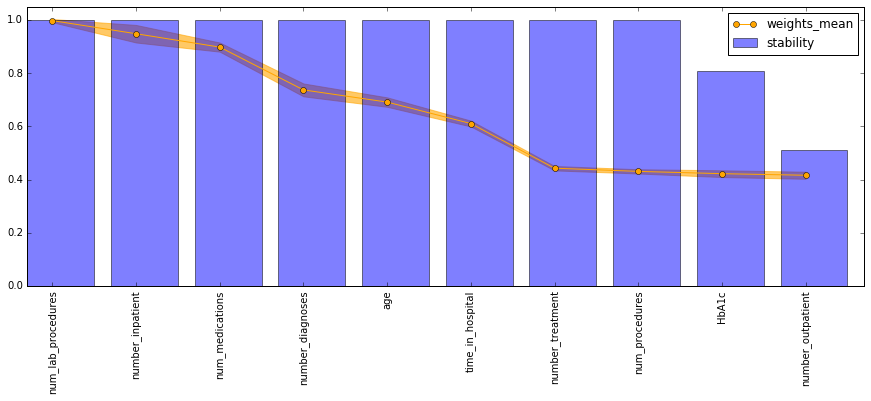

(10, 6)
(10, 6)


,column,kont,mean,std,max,min
5,num_lab_procedures,1.0000,0.9985,0.0060,1.0000,0.9580
8,number_inpatient,1.0000,0.9492,0.0330,1.0000,0.8524
0,num_medications,1.0000,0.8988,0.0171,0.9431,0.8627
3,number_diagnoses,1.0000,0.7378,0.0242,0.8099,0.6835
1,age,1.0000,0.6919,0.0177,0.7341,0.6500
2,time_in_hospital,1.0000,0.6111,0.0110,0.6499,0.5768
7,number_treatment,1.0000,0.4431,0.0083,0.4620,0.4266
9,num_procedures,1.0000,0.4311,0.0080,0.4531,0.4132
4,HbA1c,0.8100,0.4225,0.0127,0.4551,0.4020
6,number_outpatient,0.5100,0.4165,0.0133,0.4563,0.4004


,column,kont,mean,std,max,min
5,num_lab_procedures,1.0000,0.9985,0.0060,1.0000,0.9580
8,number_inpatient,1.0000,0.9492,0.0330,1.0000,0.8524
0,num_medications,1.0000,0.8988,0.0171,0.9431,0.8627
3,number_diagnoses,1.0000,0.7378,0.0242,0.8099,0.6835
1,age,1.0000,0.6919,0.0177,0.7341,0.6500
2,time_in_hospital,1.0000,0.6111,0.0110,0.6499,0.5768
7,number_treatment,1.0000,0.4431,0.0083,0.4620,0.4266
9,num_procedures,1.0000,0.4311,0.0080,0.4531,0.4132
4,HbA1c,0.8100,0.4225,0.0127,0.4551,0.4020
6,number_outpatient,0.5100,0.4165,0.0133,0.4563,0.4004


In [138]:
#Plot stability
plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.bar(np.arange(dfStab.shape[0]), dfStab["kont"], alpha=0.5, label="stability")
ax.plot(np.arange(dfStab.shape[0])+0.3, dfStab["mean"],c="orange", marker='o', label="weights_mean")
ax.fill_between(np.arange(dfStab.shape[0])+0.3, 
                dfStab["mean"] - dfStab["std"],
                dfStab["mean"] + dfStab["std"],
                alpha=0.6, color="orange")
    
plt.xticks(np.arange(dfStab.shape[0])+0.3,dfStab["column"],rotation=90)
plt.ylim(0.0,1.05)
plt.legend()
plt.show()

#Stability table
print dfStab.shape
print dfStab[dfStab["kont"]>=0.4].shape
display(dfStab[dfStab["kont"]>=0.4])
display(dfStab)

#### Learning curve

In [133]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), metric="f1"):

    plt.figure(figsize=(8,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("% Training set")
    plt.ylabel(metric + "-score")
    train_sizes_lc, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring="recall")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.axhline(0.5,color='r',ls='--', label="random")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return plt

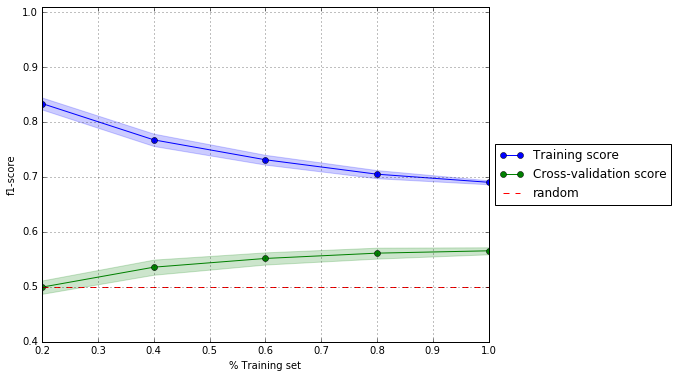

In [134]:
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
title = ""
plot_learning_curve(cls, title, X_train, y_train, ylim=(0.4, 1.01), 
                    cv=cv_outer,
                    train_sizes=[0.2,0.4,0.6,0.8,1.0], 
                    n_jobs=-1, metric="f1")

plt.show()